In [1]:
# Imports, globals, small helpers
import os
import random
import math
import glob
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import make_circles, make_classification

from lime.lime_tabular import LimeTabularExplainer
import shap
import pickle

from scipy.stats import friedmanchisquare, wilcoxon, spearmanr, kruskal, rankdata, linregress
from statsmodels.stats.multitest import multipletests


# Globals & seed
GLOBAL_SEED = 13
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
EPS = 1e-12

DEBUG_SEED_PRINTS = True
warnings.filterwarnings("ignore", category=UserWarning)

def fmt(x, n=4):
    try:
        return f"{x:.{n}f}"
    except Exception:
        return str(x)

def display_method_name(m):
    """Uniform method display: 'lime' -> 'LIME', 'kernel' -> 'Kernel', 'tree' -> 'Tree'."""
    if m.lower() == 'lime':
        return 'LIME'
    elif m.lower() == 'kernel':
        return 'Kernel'
    elif m.lower() == 'tree':
        return 'Tree'
    else:
        return m.capitalize()

In [2]:
# Vector helpers & metrics (directional + magnitude) + Top-K Jaccard

def l2_normalize(vec):
    vec = np.asarray(vec, dtype=float)
    norm = np.linalg.norm(vec)
    if norm < EPS:
        return vec
    return vec / (norm + EPS)

def pairwise_similarity_and_distance(runs_matrix):
    runs = np.asarray(runs_matrix, dtype=float)
    n_runs, n_features = runs.shape
    dists = []
    sims = []
    for i, j in combinations(range(n_runs), 2):
        d = np.linalg.norm(runs[i] - runs[j]) / float(n_features)
        s = 1.0 / (1.0 + d)
        dists.append(d)
        sims.append(s)
    if len(sims) == 0:
        return np.nan, np.nan, np.nan
    return float(np.mean(sims)), float(np.mean(dists)), float(np.std(dists, ddof=1))

def per_feature_variance(runs_matrix):
    runs = np.asarray(runs_matrix)
    return float(np.mean(np.var(runs, axis=0, ddof=1)))

def sign_flip_rate(runs_matrix):
    runs = np.asarray(runs_matrix)
    signs = np.sign(runs)
    signs[signs == 0] = 1
    n_runs, n_features = runs.shape
    flip_rates = []
    for f in range(n_features):
        feat_signs = signs[:, f]
        maj = 1 if np.sum(feat_signs == 1) >= np.sum(feat_signs == -1) else -1
        flips = np.sum(feat_signs != maj)
        flip_rates.append(flips / float(n_runs))
    return float(np.mean(flip_rates))

def icc_1_1(runs_matrix):
    X = np.asarray(runs_matrix).T
    n, k = X.shape
    if n < 2 or k < 2:
        return np.nan
    m_i = np.mean(X, axis=1)
    m = np.mean(X)
    MSB = (k / (n - 1)) * np.sum((m_i - m) ** 2)
    MSW = (1 / (n * (k - 1))) * np.sum((X - m_i[:, None]) ** 2)
    denom = MSB + (k - 1) * MSW
    if denom == 0:
        return np.nan
    icc = (MSB - MSW) / denom
    return float(icc)

def kendalls_w(runs_matrix):
    X = np.asarray(runs_matrix, dtype=float)
    m, n = X.shape  # m runs, n features
    if n < 2 or m < 2:
        return np.nan
    R = np.zeros((m, n), dtype=float)
    for i in range(m):
        R[i, :] = rankdata(np.abs(X[i, :]), method='average')
    R_j = np.sum(R, axis=0)
    R_bar = np.mean(R_j)
    S = np.sum((R_j - R_bar) ** 2)
    tie_sum = 0.0
    for i in range(m):
        ranks = R[i, :]
        unique, counts = np.unique(np.round(ranks, 8), return_counts=True)
        for c in counts:
            if c > 1:
                tie_sum += (c**3 - c)
    denom = (m**2) * (n**3 - n) / 12.0
    if denom == 0:
        return np.nan
    if tie_sum != 0:
        denom = denom - (m * tie_sum) / 12.0
        if denom <= 0:
            return np.nan
    W = (12.0 * S) / denom
    W = max(min(W, 1.0), 0.0)
    return float(W)

def norm_cv(runs_matrix):
    runs = np.asarray(runs_matrix)
    norms = np.linalg.norm(runs, axis=1)
    mean_norm = np.mean(norms)
    if mean_norm < EPS:
        return np.nan
    return float(np.std(norms, ddof=1) / mean_norm)

def mean_feature_cv(runs_matrix):
    runs = np.asarray(runs_matrix)
    n_runs, n_features = runs.shape
    cvs = []
    for f in range(n_features):
        vals = runs[:, f]
        denom = np.mean(np.abs(vals))
        if denom < EPS:
            continue
        cvs.append(np.std(vals, ddof=1) / denom)
    if len(cvs) == 0:
        return np.nan
    return float(np.mean(cvs))

def mean_norm(runs_matrix):
    runs = np.asarray(runs_matrix)
    norms = np.linalg.norm(runs, axis=1)
    return float(np.mean(norms))

def bootstrap_mean_ci(values, n_boot=1000, alpha=0.05):
    vals = np.array(values)
    if len(vals) == 0:
        return np.nan, (np.nan, np.nan)
    boot_means = []
    rng = np.random.RandomState(GLOBAL_SEED)
    for _ in range(n_boot):
        sample = rng.choice(vals, size=len(vals), replace=True)
        boot_means.append(np.mean(sample))
    lo = np.percentile(boot_means, 100 * (alpha/2))
    hi = np.percentile(boot_means, 100 * (1 - alpha/2))
    return float(np.mean(vals)), (float(lo), float(hi))

def topk_jaccard_mean_pairwise(runs_matrix, k=1):
    """
    For runs_matrix (n_runs x n_features), compute per-run top-k index sets (by absolute value)
    then compute mean pairwise Jaccard similarity among all run pairs.
    """
    runs = np.asarray(runs_matrix, dtype=float)
    n_runs, n_features = runs.shape
    if k < 1:
        return np.nan
    k = min(k, n_features)
    top_sets = []
    for r in runs:
        idx = np.argsort(-np.abs(r))[:k]
        top_sets.append(set(idx.tolist()))
    if n_runs < 2:
        return np.nan
    jaccs = []
    for i, j in combinations(range(n_runs), 2):
        A, B = top_sets[i], top_sets[j]
        inter = len(A & B)
        union = len(A | B)
        jc = inter / union if union > 0 else 0.0
        jaccs.append(jc)
    return float(np.mean(jaccs)) if len(jaccs) > 0 else np.nan


In [3]:
# Single-instance metrics wrapper
def compute_variability_metrics(runs_raw, runs_norm):
    nm = {}
    mean_sim, mean_dist, std_dist = pairwise_similarity_and_distance(runs_norm)
    nm['mean_pairwise_similarity'] = mean_sim
    nm['mean_pairwise_distance'] = mean_dist
    nm['std_pairwise_distance'] = std_dist
    nm['mean_feature_variance'] = per_feature_variance(runs_norm)
    nm['sign_flip_rate'] = sign_flip_rate(runs_norm)
    nm['icc_1_1'] = icc_1_1(runs_norm)
    nm['kendalls_w'] = kendalls_w(runs_norm)
    nm['norm_cv'] = norm_cv(runs_raw)
    nm['mean_feature_cv'] = mean_feature_cv(runs_raw)
    nm['mean_norm'] = mean_norm(runs_raw)

    # Top-k Jaccard (use k values bounded by n_features)
    n_features = runs_raw.shape[1]
    for k in [1, 3, 5]:
        kk = min(k, n_features)
        nm[f'top{kk}_jaccard'] = topk_jaccard_mean_pairwise(runs_raw, k=kk)
    return nm


RF accuracy (linear):  0.975
RF accuracy (circles): 0.99


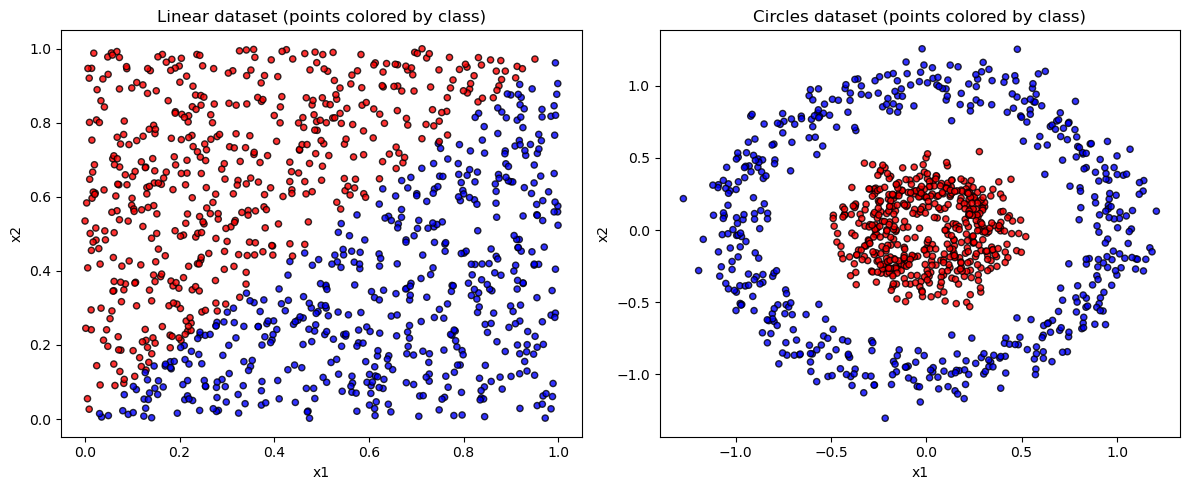

In [4]:
# Reproduce small 2D datasets & RF training (Linear and Circles)
seed = GLOBAL_SEED
np.random.seed(seed)

n_points = 1000

# Linear dataset
linear_x1 = np.random.rand(n_points)
linear_x2 = np.random.rand(n_points)
linear_y = (linear_x2 > linear_x1).astype(int)
df_linear = pd.DataFrame({'x1': linear_x1, 'x2': linear_x2, 'y': linear_y})

# Circles dataset
circles_X, circles_y = make_circles(n_samples=n_points, noise=0.1, factor=0.3, random_state=seed)
df_circles = pd.DataFrame(circles_X, columns=['x1','x2'])
df_circles['y'] = circles_y

# Train/test split and RF training
rf_params = dict(n_estimators=200, random_state=0)

# Linear
X_lin = df_linear[['x1','x2']].values
y_lin = df_linear['y'].values
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_lin, y_lin, test_size=0.2, random_state=0)
rf_lin = RandomForestClassifier(**rf_params).fit(Xl_train, yl_train)

# Circles
X_circ = df_circles[['x1','x2']].values
y_circ = df_circles['y'].values
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_circ, y_circ, test_size=0.2, random_state=0)
rf_circ = RandomForestClassifier(**rf_params).fit(Xc_train, yc_train)

print('RF accuracy (linear): ', accuracy_score(yl_test, rf_lin.predict(Xl_test)))
print('RF accuracy (circles):', accuracy_score(yc_test, rf_circ.predict(Xc_test)))

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(X_lin[:,0], X_lin[:,1], c=y_lin, cmap='bwr', edgecolor='k', s=20, alpha=0.8)
ax[0].set_title('Linear dataset (points colored by class)')
ax[0].set_xlabel('x1'); ax[0].set_ylabel('x2')

ax[1].scatter(X_circ[:,0], X_circ[:,1], c=y_circ, cmap='bwr', edgecolor='k', s=20, alpha=0.8)
ax[1].set_title('Circles dataset (points colored by class)')
ax[1].set_xlabel('x1'); ax[1].set_ylabel('x2')

plt.tight_layout()
plt.show()


In [5]:
# Explainers setup for 2D datasets and unified_explain
lime_explainer_lin = LimeTabularExplainer(
    Xl_train, feature_names=['x1','x2'], class_names=['0','1'], discretize_continuous=False, random_state=GLOBAL_SEED
)
lime_explainer_circ = LimeTabularExplainer(
    Xc_train, feature_names=['x1','x2'], class_names=['0','1'], discretize_continuous=False, random_state=GLOBAL_SEED
)

rng = np.random.RandomState(GLOBAL_SEED)
bg_lin_idx = rng.choice(Xl_train.shape[0], size=min(50, Xl_train.shape[0]), replace=False)
bg_circ_idx = rng.choice(Xc_train.shape[0], size=min(50, Xc_train.shape[0]), replace=False)
bg_lin = Xl_train[bg_lin_idx]
bg_circ = Xc_train[bg_circ_idx]

kernel_explainer_lin = shap.KernelExplainer(lambda z: rf_lin.predict_proba(z)[:,1], bg_lin)
kernel_explainer_circ = shap.KernelExplainer(lambda z: rf_circ.predict_proba(z)[:,1], bg_circ)

tree_explainer_lin = shap.TreeExplainer(rf_lin)
tree_explainer_circ = shap.TreeExplainer(rf_circ)

def unified_explain(instance, method, ds_info, nsamples_kernel=2000, nsamples_lime=5000):
    n_features = instance.shape[0]
    if method == 'tree':
        explainer = ds_info['tree_explainer']
        shap_vals = explainer.shap_values(instance.reshape(1, -1))
        if isinstance(shap_vals, (list, tuple)):
            vec = np.asarray(shap_vals[1]).reshape(-1)[:n_features]
        else:
            vec = np.asarray(shap_vals).reshape(-1)[:n_features]
    elif method == 'kernel':
        explainer = ds_info['kernel_explainer']
        shap_vals = explainer.shap_values(instance.reshape(1, -1), nsamples=nsamples_kernel)
        if isinstance(shap_vals, (list, tuple)):
            vec = np.asarray(shap_vals[1]).reshape(-1)[:n_features]
        else:
            vec = np.asarray(shap_vals).reshape(-1)[:n_features]
    elif method == 'lime':
        explainer = ds_info['lime_explainer']
        model = ds_info['model']
        exp = explainer.explain_instance(
            instance, model.predict_proba, num_features=n_features, num_samples=nsamples_lime, labels=(1,)
        )
        alist = exp.as_list(label=1)
        weights = np.zeros(n_features)
        import re
        for feat_name, weight in alist:
            m = re.search(r"x(\d+)", feat_name)
            if m:
                idx = int(m.group(1)) - 1
                if 0 <= idx < n_features:
                    weights[idx] = weight
        vec = weights
    else:
        raise ValueError("Unknown method")
    return np.asarray(vec, dtype=float)

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if DEBUG_SEED_PRINTS:
        print(f"[seed check] numpy.rand: {np.random.rand():.6f}, random.random: {random.random():.6f}, seed={seed}")


In [6]:
# # Compute explanations for 2D datasets and SAVE raw outputs to CSVs
N_RUNS = 30
KERNEL_NSAMPLES = 2000
LIME_NUM_SAMPLES = 5000

datasets_2d = {
    'Linear': {
        'model': rf_lin, 'X_test': Xl_test, 'X_train': Xl_train,
        'lime_explainer': lime_explainer_lin, 'kernel_explainer': kernel_explainer_lin, 'tree_explainer': tree_explainer_lin
    },
    'Circles': {
        'model': rf_circ, 'X_test': Xc_test, 'X_train': Xc_train,
        'lime_explainer': lime_explainer_circ, 'kernel_explainer': kernel_explainer_circ, 'tree_explainer': tree_explainer_circ
    }
}

In [ ]:
# Comment if necessary

for ds_name, ds_info in datasets_2d.items():
    rows = []
    X_test = ds_info['X_test']
    model = ds_info['model']
    n_features = X_test.shape[1]
    print(f"Computing explanations for '{ds_name}' ({X_test.shape[0]} test instances)...")
    for i_instance in tqdm(range(X_test.shape[0]), desc=f"{ds_name} explanations"):
        x = X_test[i_instance]
        proba = model.predict_proba(x.reshape(1, -1))[0,1]
        margin = abs(proba - 0.5)
        for method in ['tree','kernel','lime']:
            for run_idx in range(N_RUNS):
                seed_run = GLOBAL_SEED + 1000*run_idx
                set_all_seeds(seed_run)
                vec_raw = unified_explain(x, method, {**ds_info, 'model': model}, nsamples_kernel=KERNEL_NSAMPLES, nsamples_lime=LIME_NUM_SAMPLES)
                row = {
                    'dataset': ds_name,
                    'instance_idx': int(i_instance),
                    'method': method,
                    'run_idx': int(run_idx),
                    'proba': float(proba),
                    'margin': float(margin)
                }
                for f in range(n_features):
                    row[f'x{f+1}_raw'] = float(vec_raw[f])
                rows.append(row)
    df_exp = pd.DataFrame(rows)
    fname = f"{ds_name.replace(' ','')}_Explanations_raw.csv"
    df_exp.to_csv(fname, index=False)
    print(f"Saved raw explanations to {fname} ({df_exp.shape[0]} rows)")


Upon initial execution of the code, users are encouraged to comment the cell above (the one that generate explanations and save them) to prevent the code from executing again, which can be time-consuming.

In [8]:
# Load 2D explanations, build metrics_store, and small helper to build
linear_fname = 'Linear_Explanations_raw.csv'
circles_fname = 'Circles_Explanations_raw.csv'
assert os.path.exists(linear_fname), f"{linear_fname} not found. Run Cell 6 first."
assert os.path.exists(circles_fname), f"{circles_fname} not found. Run Cell 6 first."
df_linear_exp = pd.read_csv(linear_fname)
df_circles_exp = pd.read_csv(circles_fname)
print(f"Loaded {linear_fname} shape: {df_linear_exp.shape}")
print(f"Loaded {circles_fname} shape: {df_circles_exp.shape}")

def build_from_raw_df(df, n_runs_expected=30):
    methods = sorted(df['method'].unique())
    instance_count = int(df['instance_idx'].max() + 1)
    raw_cols = sorted([c for c in df.columns if c.endswith('_raw')], key=lambda x: int(x.split('x')[1].split('_')[0]))
    n_features = len(raw_cols)
    metrics_store = {m: [] for m in methods}
    all_run_attributions = {m: [] for m in methods}
    margins = np.zeros(instance_count)
    for i in range(instance_count):
        df_i = df[df['instance_idx'] == i]
        margins[i] = float(df_i['margin'].iloc[0])
        for m in methods:
            df_m = df_i[df_i['method'] == m].sort_values('run_idx')
            runs_raw = df_m[raw_cols].values
            runs_norm = np.vstack([l2_normalize(r) for r in runs_raw])
            all_run_attributions[m].append({'raw': runs_raw, 'norm': runs_norm})
            metrics_store[m].append(compute_variability_metrics(runs_raw, runs_norm))
    return metrics_store, margins, all_run_attributions

metrics_store = {}
margins_store = {}
all_run_attributions = {}
metrics_store['Linear'], margins_store['Linear'], all_run_attributions['Linear'] = build_from_raw_df(df_linear_exp, n_runs_expected=N_RUNS)
metrics_store['Circles'], margins_store['Circles'], all_run_attributions['Circles'] = build_from_raw_df(df_circles_exp, n_runs_expected=N_RUNS)
print("Reconstructed metrics_store and all_run_attributions for Linear and Circles.")


Loaded Linear_Explanations_raw.csv shape: (18000, 8)
Loaded Circles_Explanations_raw.csv shape: (18000, 8)
Reconstructed metrics_store and all_run_attributions for Linear and Circles.


In [9]:
# Summary table (pairwise similarity) and save (uses display method names where printed)
summary_rows = []
for ds in metrics_store:
    for method in sorted(metrics_store[ds].keys()):
        vals = np.array([m['mean_pairwise_similarity'] for m in metrics_store[ds][method]])
        vals_ok = vals[~np.isnan(vals)]
        mean_val = float(np.nanmean(vals)) if vals_ok.size>0 else np.nan
        std_val = float(np.nanstd(vals, ddof=1)) if vals_ok.size>1 else np.nan
        mean_overall, (lo, hi) = bootstrap_mean_ci(vals_ok, n_boot=1000, alpha=0.05) if vals_ok.size>0 else (np.nan, (np.nan, np.nan))
        n_instances = int(np.sum(~np.isnan(vals)))
        note = ''
        if n_instances == 0:
            note = 'no valid instances'
        elif vals_ok.size>0 and np.allclose(vals_ok, vals_ok[0]):
            note = 'zero variability across instances (degenerate)'
        summary_rows.append({
            'dataset': ds, 'method': method,
            'method_display': display_method_name(method),
            'mean_pairwise_similarity': mean_val, 'std_pairwise_similarity': std_val,
            '95ci_lo': lo, '95ci_hi': hi, 'n_instances': n_instances, 'note': note
        })

summary_df = pd.DataFrame(summary_rows)
summary_df[['mean_pairwise_similarity','std_pairwise_similarity','95ci_lo','95ci_hi']] = summary_df[['mean_pairwise_similarity','std_pairwise_similarity','95ci_lo','95ci_hi']].round(4)
summary_df.to_csv('pairwise_similarity_summary.csv', index=False)
print("Saved pairwise_similarity_summary.csv")
display(summary_df)


Saved pairwise_similarity_summary.csv


,dataset,method,method_display,mean_pairwise_similarity,std_pairwise_similarity,95ci_lo,95ci_hi,n_instances,note
0,Linear,kernel,Kernel,1.0000,0.0000,1.0000,1.0000,200,zero variability across instances (degenerate)
1,Linear,lime,LIME,0.9939,0.0012,0.9937,0.9941,200,
2,Linear,tree,Tree,1.0000,0.0000,1.0000,1.0000,200,zero variability across instances (degenerate)
3,Circles,kernel,Kernel,1.0000,0.0000,1.0000,1.0000,200,zero variability across instances (degenerate)
4,Circles,lime,LIME,0.9800,0.0188,0.9771,0.9822,200,
5,Circles,tree,Tree,1.0000,0.0000,1.0000,1.0000,200,zero variability across instances (degenerate)


In [10]:
# Statistical tests (Friedman across methods)
def wilcoxon_with_effect(a, b, alternative='two-sided'):
    a = np.asarray(a); b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    a1, b1 = a[mask], b[mask]
    diff = a1 - b1
    nz = diff != 0
    if nz.sum() < 1:
        return {'stat': np.nan, 'p': np.nan, 'n': int(nz.sum()), 'rank_biserial': np.nan}
    stat, p = wilcoxon(a1[nz], b1[nz], alternative=alternative)
    ranks = rankdata(np.abs(diff[nz]))
    pos = np.sum(ranks[diff[nz] > 0])
    neg = np.sum(ranks[diff[nz] < 0])
    rank_biserial = (pos - neg) / (pos + neg)
    return {'stat': float(stat), 'p': float(p), 'n': int(nz.sum()), 'rank_biserial': float(rank_biserial)}

def paired_permutation_test(a, b, n_perms=5000, rng_seed=GLOBAL_SEED):
    a = np.asarray(a); b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    a1, b1 = a[mask], b[mask]
    if a1.size == 0:
        return {'p': np.nan, 'obs_diff': np.nan}
    obs_diff = np.mean(a1 - b1)
    rng = np.random.RandomState(rng_seed)
    perm_diffs = []
    for _ in range(n_perms):
        signs = rng.choice([1, -1], size=a1.size)
        diff = np.mean(signs * (a1 - b1))
        perm_diffs.append(diff)
    perm_diffs = np.array(perm_diffs)
    p = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
    return {'p': float(p), 'obs_diff': float(obs_diff), 'perm_diffs': perm_diffs}

friedman_summary = []
for ds in sorted(metrics_store.keys()):
    methods = sorted(metrics_store[ds].keys())
    data_matrix = []
    for m in methods:
        arr = np.array([x['mean_pairwise_similarity'] for x in metrics_store[ds][m]])
        data_matrix.append(arr)
    mat = np.vstack(data_matrix)
    mask = ~np.isnan(mat).any(axis=0)
    mat_ok = mat[:, mask]
    if mat_ok.shape[1] < 3:
        friedman_summary.append({'dataset': ds, 'test': 'friedman', 'stat': np.nan, 'p': np.nan, 'n_complete_instances': int(mat_ok.shape[1]), 'note': 'not enough complete instances'})
        continue
    if np.allclose(mat_ok, mat_ok[:,0][:,None]):
        friedman_summary.append({'dataset': ds, 'test': 'friedman', 'stat': 0.0, 'p': 1.0, 'n_complete_instances': int(mat_ok.shape[1]), 'note': 'no variability across methods'})
        continue
    try:
        stat, p = friedmanchisquare(*[mat_ok[i] for i in range(mat_ok.shape[0])])
        N_blocks = mat_ok.shape[1]
        k_methods = mat_ok.shape[0]
        kendall_w_friedman = stat / (N_blocks * (k_methods - 1)) if (N_blocks*(k_methods-1)) != 0 else np.nan
        entry = {'dataset': ds, 'test': 'friedman', 'stat': float(stat), 'p': float(p), 'kendall_w': float(kendall_w_friedman), 'n_complete_instances': int(N_blocks), 'note': ''}
    except Exception as e:
        entry = {'dataset': ds, 'test': 'friedman', 'stat': np.nan, 'p': np.nan, 'kendall_w': np.nan, 'n_complete_instances': int(mat_ok.shape[1]), 'note': 'friedman failed'}
    pairwise = []
    if entry.get('p') is not None and not np.isnan(entry.get('p')) and entry.get('p') < 0.05:
        pairs = list(combinations(range(mat_ok.shape[0]), 2))
        m_pairs = len(pairs)
        for a,b in pairs:
            try:
                res = wilcoxon_with_effect(mat_ok[a], mat_ok[b])
                pw = res['p']; rb = res['rank_biserial']
                pw_adj = min(pw * m_pairs, 1.0) if not np.isnan(pw) else np.nan
                pairwise.append({'pair': f"{methods[a]} vs {methods[b]}", 'wilcoxon_p': pw, 'wilcoxon_p_bonf': pw_adj, 'rank_biserial': rb})
            except Exception:
                perm = paired_permutation_test(mat_ok[a], mat_ok[b], n_perms=5000)
                pairwise.append({'pair': f"{methods[a]} vs {methods[b]}", 'wilcoxon_p': np.nan, 'wilcoxon_p_bonf': np.nan, 'rank_biserial': np.nan, 'perm_p': perm['p']})
    entry['pairwise'] = pairwise
    friedman_summary.append(entry)

rows_for_csv = []
for e in friedman_summary:
    base = {'dataset': e['dataset'], 'test': e['test'], 'stat': e.get('stat', np.nan), 'p': e.get('p', np.nan), 'kendall_w': e.get('kendall_w', np.nan), 'n_complete_instances': e['n_complete_instances'], 'note': e['note']}
    rows_for_csv.append(base)
    if e.get('pairwise'):
        for p in e['pairwise']:
            rows_for_csv.append({'dataset': e['dataset'], 'test': 'pairwise', 'pair': p['pair'], 'wilcoxon_p': p.get('wilcoxon_p'), 'wilcoxon_p_bonf': p.get('wilcoxon_p_bonf'), 'rank_biserial': p.get('rank_biserial'), 'perm_p': p.get('perm_p', np.nan)})

friedman_df = pd.DataFrame(rows_for_csv)
display(friedman_df)


,dataset,test,stat,p,kendall_w,n_complete_instances,note,pair,wilcoxon_p,wilcoxon_p_bonf,rank_biserial,perm_p
0,Circles,friedman,400.0,1.383897e-87,1.0,200.0,,NaN,NaN,NaN,NaN,NaN
1,Circles,pairwise,NaN,NaN,NaN,NaN,NaN,kernel vs lime,1.436146e-34,4.308439e-34,1.0,NaN
2,Circles,pairwise,NaN,NaN,NaN,NaN,NaN,kernel vs tree,NaN,NaN,NaN,NaN
3,Circles,pairwise,NaN,NaN,NaN,NaN,NaN,lime vs tree,1.436146e-34,4.308439e-34,-1.0,NaN
4,Linear,friedman,400.0,1.383897e-87,1.0,200.0,,NaN,NaN,NaN,NaN,NaN
5,Linear,pairwise,NaN,NaN,NaN,NaN,NaN,kernel vs lime,1.436146e-34,4.308439e-34,1.0,NaN
6,Linear,pairwise,NaN,NaN,NaN,NaN,NaN,kernel vs tree,NaN,NaN,NaN,NaN
7,Linear,pairwise,NaN,NaN,NaN,NaN,NaN,lime vs tree,1.436146e-34,4.308439e-34,-1.0,NaN


In [11]:
# Improved helper plots + consensus functions (uses display_method_name for titles)
def scatter_feature_values_from_saved(all_run_attributions, ds_name, method, instance_idx):
    runs = all_run_attributions[method][instance_idx]['raw']
    n_runs, n_features = runs.shape
    norm_runs = np.vstack([l2_normalize(r) for r in runs])
    mean_sim, _, _ = pairwise_similarity_and_distance(norm_runs)
    plt.figure(figsize=(10,5))
    for f in range(n_features):
        plt.scatter(runs[:, f], range(n_runs), label=f"x{f+1}", s=30)
    plt.xlabel('Explanation Value (raw importance)')
    plt.ylabel('Run Index')
    plt.title(f"{ds_name} | {display_method_name(method)} | instance {instance_idx} | mean_sim={fmt(mean_sim,3)}")
    plt.yticks(range(n_runs))
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_methods_feature_scatter_from_saved(all_run_attributions, ds_name, instance_idx, method_a, method_b):
    runs_a = all_run_attributions[method_a][instance_idx]['raw']
    runs_b = all_run_attributions[method_b][instance_idx]['raw']
    norm_a = np.vstack([l2_normalize(r) for r in runs_a])
    norm_b = np.vstack([l2_normalize(r) for r in runs_b])
    sim_a, _, _ = pairwise_similarity_and_distance(norm_a)
    sim_b, _, _ = pairwise_similarity_and_distance(norm_b)
    n_features = runs_a.shape[1]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for f in range(n_features):
        plt.scatter(runs_a[:,f], range(runs_a.shape[0]), s=25, label=f'x{f+1}')
    plt.title(f"{ds_name} - {display_method_name(method_a)} (inst {instance_idx}) | mean_sim={fmt(sim_a,3)}")
    plt.xlabel('Explanation Value (raw importance)'); plt.ylabel('Run Index')
    plt.subplot(1,2,2)
    for f in range(n_features):
        plt.scatter(runs_b[:,f], range(runs_b.shape[0]), s=25, label=f'x{f+1}')
    plt.title(f"{ds_name} - {display_method_name(method_b)} (inst {instance_idx}) | mean_sim={fmt(sim_b,3)}")
    plt.xlabel('Explanation Value (raw importance)')
    plt.tight_layout()
    plt.show()

def compute_consensus_and_distances(runs_raw, method='median'):
    runs = np.asarray(runs_raw, dtype=float)
    n_runs, n_features = runs.shape
    if method == 'median':
        consensus = np.median(runs, axis=0)
    else:
        consensus = np.mean(runs, axis=0)
    distances_raw = np.linalg.norm(runs - consensus[None, :], axis=1)
    mean_raw = float(np.mean(distances_raw))
    norm_runs = np.vstack([l2_normalize(r) for r in runs])
    norm_cons = l2_normalize(consensus)
    d_dir = np.linalg.norm(norm_runs - norm_cons[None, :], axis=1) / float(n_features)
    similarities_dir = 1.0 / (1.0 + d_dir)
    return {
        'consensus_raw': consensus,
        'distances_raw': distances_raw,
        'mean_distance_raw': mean_raw,
        'distances_dir': d_dir,
        'similarities_dir': similarities_dir,
        'mean_similarity_dir': float(np.mean(similarities_dir))
    }

def global_consensus_summary(all_run_attributions, method_list=None, instance_idx_sample=None):
    methods = method_list or sorted(all_run_attributions.keys())
    per_method_summary = {}
    if instance_idx_sample is None:
        for m in methods:
            sims = []
            mean_raws = []
            for inst in range(len(all_run_attributions[m])):
                runs_raw = all_run_attributions[m][inst]['raw']
                info = compute_consensus_and_distances(runs_raw, method='median')
                sims.append(info['mean_similarity_dir'])
                mean_raws.append(info['mean_distance_raw'])
            per_method_summary[m] = {'mean_sim_to_consensus': float(np.mean(sims)), 'sim_ci': bootstrap_mean_ci(sims, n_boot=1000)[1], 'mean_raw_dist': float(np.mean(mean_raws))}
    else:
        for m in methods:
            runs_raw = all_run_attributions[m][instance_idx_sample]['raw']
            info = compute_consensus_and_distances(runs_raw, method='median')
            per_method_summary[m] = {'mean_sim_to_consensus': info['mean_similarity_dir'], 'mean_raw_dist': info['mean_distance_raw']}
    return per_method_summary


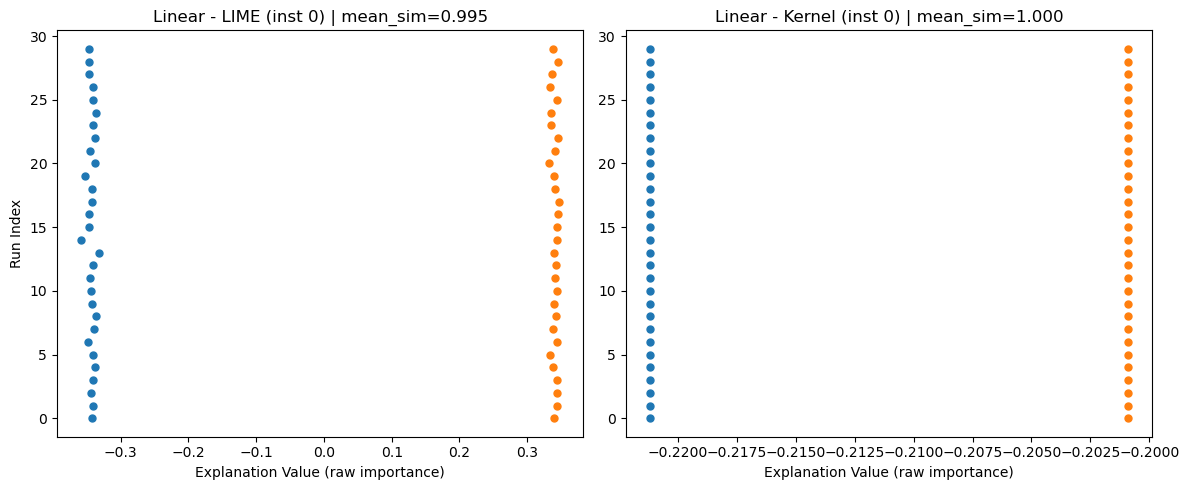

In [12]:
# Example compare:
compare_methods_feature_scatter_from_saved(all_run_attributions['Linear'], 'Linear', instance_idx=0, method_a='lime', method_b='kernel')

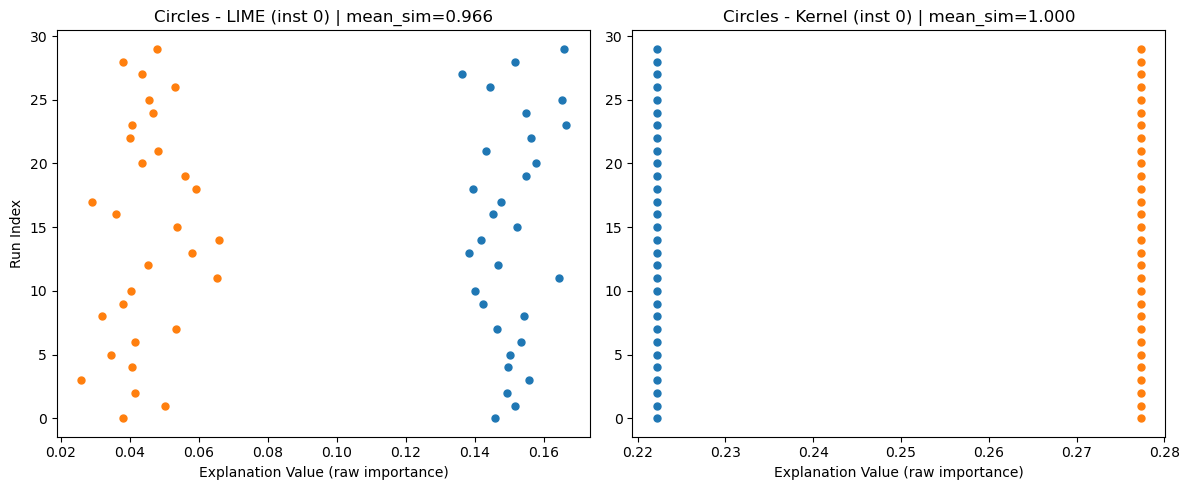

In [13]:
# Example compare:
compare_methods_feature_scatter_from_saved(all_run_attributions['Circles'], 'Circles', instance_idx=0, method_a='lime', method_b='kernel')

## Margin vs. Similarity

Saved spearman_margin_similarity_Linear.csv


/var/folders/5w/ts8c5v8s2ws2qn6p8d9706tm0000gn/T/ipykernel_82421/77415848.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(sub.loc[mask,'margin'], sub.loc[mask,'mean_pairwise_similarity'])


,dataset,method,spearman_rho,spearman_p,n,note
0,Linear,kernel,NaN,NaN,200,
1,Linear,lime,-0.440103,6.991293e-11,200,
2,Linear,tree,NaN,NaN,200,


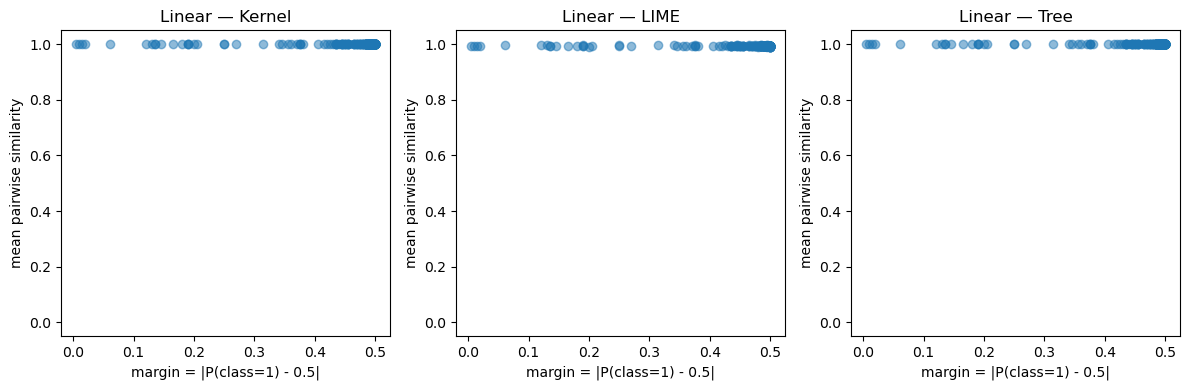

Saved spearman_margin_similarity_Circles.csv


/var/folders/5w/ts8c5v8s2ws2qn6p8d9706tm0000gn/T/ipykernel_82421/77415848.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(sub.loc[mask,'margin'], sub.loc[mask,'mean_pairwise_similarity'])


,dataset,method,spearman_rho,spearman_p,n,note
0,Circles,kernel,NaN,NaN,200,
1,Circles,lime,-0.299315,0.000017,200,
2,Circles,tree,NaN,NaN,200,


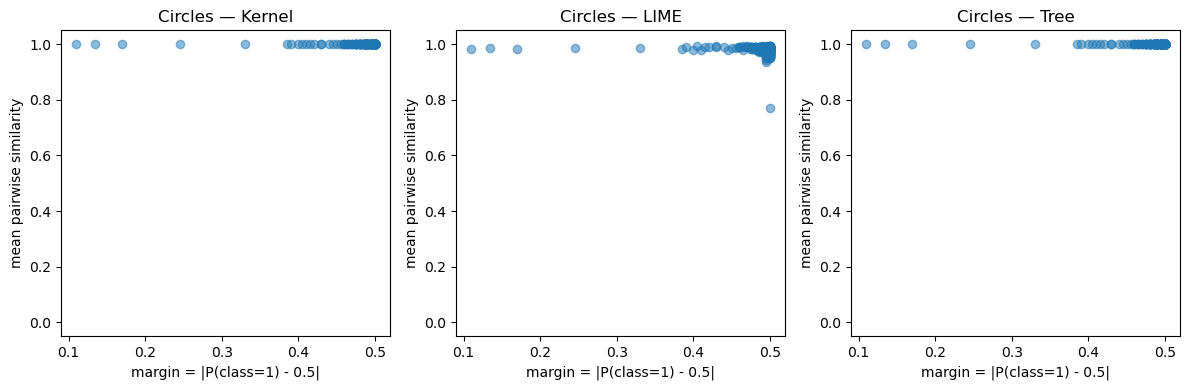

In [14]:
# Analyze margin vs similarity for small datasets and save Spearman table
def analyze_margin_relationship_and_save(metrics_store, margins_store, ds_name):
    methods = sorted(metrics_store[ds_name].keys())
    rows = []
    for i in range(len(margins_store[ds_name])):
        for m in methods:
            rows.append({'instance_idx': i, 'method': m, 'mean_pairwise_similarity': metrics_store[ds_name][m][i]['mean_pairwise_similarity'], 'margin': margins_store[ds_name][i]})
    df = pd.DataFrame(rows)
    spearman_rows = []
    for m in methods:
        sub = df[df['method']==m]
        mask = sub['mean_pairwise_similarity'].notna() & sub['margin'].notna()
        if mask.sum() < 3:
            spearman_rows.append({'dataset': ds_name, 'method': m, 'spearman_rho': np.nan, 'spearman_p': np.nan, 'n': int(mask.sum()), 'note': 'not enough data'})
            continue
        rho, p = spearmanr(sub.loc[mask,'margin'], sub.loc[mask,'mean_pairwise_similarity'])
        spearman_rows.append({'dataset': ds_name, 'method': m, 'spearman_rho': float(rho), 'spearman_p': float(p), 'n': int(mask.sum()), 'note': ''})
    spearman_df = pd.DataFrame(spearman_rows)
    outname = f"spearman_margin_similarity_{ds_name}.csv"
    spearman_df.to_csv(outname, index=False)
    print(f"Saved {outname}")
    display(spearman_df)
    plt.figure(figsize=(12,4))
    for i, m in enumerate(methods, 1):
        plt.subplot(1,len(methods),i)
        sub = df[df['method']==m]
        plt.scatter(sub['margin'], sub['mean_pairwise_similarity'], alpha=0.5)
        plt.xlabel('margin = |P(class=1) - 0.5|')
        plt.ylabel('mean pairwise similarity')
        plt.title(f"{ds_name} — {display_method_name(m)}")
        plt.ylim(-0.05,1.05)
    plt.tight_layout()
    plt.show()
    return spearman_df

spearman_linear = analyze_margin_relationship_and_save(metrics_store, margins_store, 'Linear')
spearman_circles = analyze_margin_relationship_and_save(metrics_store, margins_store, 'Circles')


In [15]:
spearman_circles

,dataset,method,spearman_rho,spearman_p,n,note
0,Circles,kernel,NaN,NaN,200,
1,Circles,lime,-0.299315,0.000017,200,
2,Circles,tree,NaN,NaN,200,


In [16]:
spearman_linear

,dataset,method,spearman_rho,spearman_p,n,note
0,Linear,kernel,NaN,NaN,200,
1,Linear,lime,-0.440103,6.991293e-11,200,
2,Linear,tree,NaN,NaN,200,


## Multi-Feature Analysis

In [17]:
# MULTI-FEATURE experiments: compute explanations, save raw outputs, and produce per-instance CSVs
feature_sizes = [2, 3, 5, 10, 15]
n_samples = 500
N_runs = 30
kernel_nsamples = 1000
lime_nsamples = 2000

def kernel_bg_for_X(X_train, bg_size=50, seed=GLOBAL_SEED):
    rng = np.random.RandomState(seed)
    idx = rng.choice(X_train.shape[0], size=min(bg_size, X_train.shape[0]), replace=False)
    return X_train[idx]

def make_linear_sum_dataset(n_samples, n_features, seed=GLOBAL_SEED, noise_std=0.1):
    rng = np.random.RandomState(seed)
    X = rng.rand(n_samples, n_features)
    k_info = min(5, n_features)
    w = np.zeros(n_features)
    w[:k_info] = rng.randn(k_info)
    linear_scores = X.dot(w)
    threshold = np.median(linear_scores)
    noise = rng.normal(scale=noise_std, size=n_samples)
    y = (linear_scores + noise > threshold).astype(int)
    return X, y


def make_sklearn_classification(n_samples, n_features, n_informative=None, seed=GLOBAL_SEED):
    n_informative = n_informative or min(5, n_features)
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_informative=n_informative, n_redundant=0,
                               n_repeated=0, n_clusters_per_class=2,
                               class_sep=1.0, random_state=seed)
    return X, y

def make_gaussian_ball(
    n_samples,
    n_features,
    seed=GLOBAL_SEED,
    radius_quantile=0.5):
    rng = np.random.RandomState(seed)
    X = rng.normal(0, 1, size=(n_samples, n_features))
    dists = np.linalg.norm(X, axis=1)
    radius = np.quantile(dists, radius_quantile)
    y = (dists < radius).astype(int)
    return X, y

In [ ]:
# Comment if necessary
big_results_meta = {}
rf_performance_records = []

for n_features in feature_sizes:
    print(f"\n=== Running experiments for n_features = {n_features} ===")
    families = {
        'Linear_sum': make_linear_sum_dataset(n_samples, n_features, seed=GLOBAL_SEED),
        'Spherical Gaussian Ball': make_gaussian_ball(n_samples, n_features, seed=GLOBAL_SEED),
        'sklearn_clf': make_sklearn_classification(n_samples, n_features, n_informative=min(5,n_features), seed=GLOBAL_SEED)
    }
    for family_name, (X, y) in families.items():
        print(f" Dataset family: {family_name} (n_features={n_features})")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        model = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train, y_train)

        # Record RF performance (accuracy and AUC if possible)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        auc = np.nan
        try:
            if len(np.unique(y_test)) == 2:
                auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        except Exception:
            auc = np.nan
        rf_performance_records.append({'n_features': n_features, 'dataset_family': family_name, 'n_instances_test': X_test.shape[0], 'rf_accuracy': float(acc), 'rf_auc': (float(auc) if not np.isnan(auc) else np.nan)})

        lime_expl = LimeTabularExplainer(X_train, feature_names=[f'x{i+1}' for i in range(n_features)],
                                        class_names=[str(c) for c in np.unique(y_train)],
                                        discretize_continuous=False, random_state=GLOBAL_SEED)

        bg = kernel_bg_for_X(X_train, bg_size=50, seed=GLOBAL_SEED)
        kernel_expl = shap.KernelExplainer(lambda z: model.predict_proba(z)[:,1], bg)
        tree_expl = shap.TreeExplainer(model)

        ds_info = {'model': model, 'tree_explainer': tree_expl, 'kernel_explainer': kernel_expl, 'lime_explainer': lime_expl, 'X_train': X_train}

        rows = []
        for i_instance in tqdm(range(X_test.shape[0]), desc=f"{family_name} nfeat={n_features}"):
            x = X_test[i_instance]
            proba = model.predict_proba(x.reshape(1,-1))[0,1]
            margin = abs(proba - 0.5)

            # If low-dim (2D) plot the dataset colored by class for quick visual checks
            if n_features == 2 and i_instance == 0:
                # plot whole test set once for this family/n_features combination
                plt.figure(figsize=(6,5))
                plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr', edgecolor='k', s=30, alpha=0.8)
                plt.title(f"{family_name} (n_features=2) - points colored by class")
                plt.xlabel('x1'); plt.ylabel('x2')
                plt.show()

            for method in ['tree','kernel','lime']:
                for run_idx in range(N_runs):
                    seed_run = GLOBAL_SEED + 1000*run_idx
                    set_all_seeds(seed_run)
                    vec_raw = unified_explain(x, method, ds_info, nsamples_kernel=kernel_nsamples, nsamples_lime=lime_nsamples)
                    row = {
                        'n_features': int(n_features), 'dataset_family': family_name, 'instance_idx': int(i_instance),
                        'method': method, 'run_idx': int(run_idx), 'proba': float(proba), 'margin': float(margin)
                    }
                    for f in range(n_features):
                        row[f'x{f+1}_raw'] = float(vec_raw[f])
                    rows.append(row)
        df_family = pd.DataFrame(rows)
        fname = f"big_raw_nfeat{n_features}_{family_name}.csv"
        df_family.to_csv(fname, index=False)
        print(f"  Saved raw explanations: {fname} ({df_family.shape[0]} rows)")
        big_results_meta.setdefault(n_features, {})[family_name] = {'csv': fname, 'n_instances': X_test.shape[0]}

# Save RF performance table
df_rf_perf = pd.DataFrame(rf_performance_records)
df_rf_perf.to_csv('rf_performance_summary.csv', index=False)
print("\nSaved rf_performance_summary.csv")
display(df_rf_perf)


In [19]:
# big_results_meta = {}
# rf_performance_records = []

# for n_features in feature_sizes:
#     print(f"\n=== Running experiments for n_features = {n_features} ===")
#     families = {
#         'Linear_sum': make_linear_sum_dataset(n_samples, n_features, seed=GLOBAL_SEED),
#         'Spherical Gaussian Ball': make_gaussian_ball(n_samples, n_features, seed=GLOBAL_SEED),
#         'sklearn_clf': make_sklearn_classification(n_samples, n_features, n_informative=min(5,n_features), seed=GLOBAL_SEED)
#     }
#     for family_name, (X, y) in families.items():
#         print(f" Dataset family: {family_name} (n_features={n_features})")
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#         model = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train, y_train)

#         # Record RF performance (accuracy and AUC if possible)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test, y_pred)
#         auc = np.nan
#         try:
#             if len(np.unique(y_test)) == 2:
#                 auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
#         except Exception:
#             auc = np.nan
#         rf_performance_records.append({'n_features': n_features, 'dataset_family': family_name, 'n_instances_test': X_test.shape[0], 'rf_accuracy': float(acc), 'rf_auc': (float(auc) if not np.isnan(auc) else np.nan)})

#         lime_expl = LimeTabularExplainer(X_train, feature_names=[f'x{i+1}' for i in range(n_features)],
#                                         class_names=[str(c) for c in np.unique(y_train)],
#                                         discretize_continuous=False, random_state=GLOBAL_SEED)

#         bg = kernel_bg_for_X(X_train, bg_size=50, seed=GLOBAL_SEED)
#         kernel_expl = shap.KernelExplainer(lambda z: model.predict_proba(z)[:,1], bg)
#         tree_expl = shap.TreeExplainer(model)

#         ds_info = {'model': model, 'tree_explainer': tree_expl, 'kernel_explainer': kernel_expl, 'lime_explainer': lime_expl, 'X_train': X_train}

#         rows = []
#         for i_instance in tqdm(range(X_test.shape[0]), desc=f"{family_name} nfeat={n_features}"):
#             x = X_test[i_instance]
#             proba = model.predict_proba(x.reshape(1,-1))[0,1]
#             margin = abs(proba - 0.5)

#             # If low-dim (2D) plot the dataset colored by class for quick visual checks
#             if n_features == 2 and i_instance == 0:
#                 # plot whole test set once for this family/n_features combination
#                 plt.figure(figsize=(6,5))
#                 plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr', edgecolor='k', s=30, alpha=0.8)
#                 plt.title(f"{family_name} (n_features=2) - points colored by class")
#                 plt.xlabel('x1'); plt.ylabel('x2')
#                 plt.show()

#             for method in ['tree','kernel','lime']:
#                 for run_idx in range(N_runs):
#                     seed_run = GLOBAL_SEED + 1000*run_idx
#                     set_all_seeds(seed_run)
#                     vec_raw = unified_explain(x, method, ds_info, nsamples_kernel=kernel_nsamples, nsamples_lime=lime_nsamples)
#                     row = {
#                         'n_features': int(n_features), 'dataset_family': family_name, 'instance_idx': int(i_instance),
#                         'method': method, 'run_idx': int(run_idx), 'proba': float(proba), 'margin': float(margin)
#                     }
#                     for f in range(n_features):
#                         row[f'x{f+1}_raw'] = float(vec_raw[f])
#                     rows.append(row)
#         df_family = pd.DataFrame(rows)
#         fname = f"big_raw_nfeat{n_features}_{family_name}.csv"
#         df_family.to_csv(fname, index=False)
#         print(f"  Saved raw explanations: {fname} ({df_family.shape[0]} rows)")
#         big_results_meta.setdefault(n_features, {})[family_name] = {'csv': fname, 'n_instances': X_test.shape[0]}

# # Save RF performance table
# df_rf_perf = pd.DataFrame(rf_performance_records)
# df_rf_perf.to_csv('rf_performance_summary.csv', index=False)
# print("\nSaved rf_performance_summary.csv")
# display(df_rf_perf)


Upon initial execution of the code, users are encouraged to comment the cell above (the one that generate explanations and save them) to prevent the code from executing again, which is time-consuming.

In [20]:
# Load big multi-feature raw CSVs, compute per-instance metrics (including top-k jaccard)
files = sorted(glob.glob("big_raw_nfeat*.csv"))
print("Found big raw CSVs:", files)

big_rows = []
for fname in files:
    print("Loading", fname)
    df = pd.read_csv(fname)
    n_features = int(df.filter(like='_raw').shape[1])
    groups = df.groupby(['n_features','dataset_family','instance_idx','method'])
    for (nf, family, iid, method), g in groups:
        runs_raw = g.sort_values('run_idx')[[f'x{i+1}_raw' for i in range(n_features)]].values
        runs_norm = np.vstack([l2_normalize(r) for r in runs_raw])
        metrics = compute_variability_metrics(runs_raw, runs_norm)
        row = {'n_features': int(nf), 'dataset_family': family, 'instance_idx': int(iid), 'method': method}
        row.update(metrics)
        row['margin'] = float(g['margin'].iloc[0])
        big_rows.append(row)
df_big_per_instance = pd.DataFrame(big_rows)
df_big_per_instance.to_csv('big_results_per_instance.csv', index=False)
print("Saved big_results_per_instance.csv (per-instance metrics computed from raw explanations).")
display(df_big_per_instance.head())


Found big raw CSVs: ['big_raw_nfeat10_Linear_sum.csv', 'big_raw_nfeat10_Spherical Gaussian Ball.csv', 'big_raw_nfeat10_sklearn_clf.csv', 'big_raw_nfeat15_Linear_sum.csv', 'big_raw_nfeat15_Spherical Gaussian Ball.csv', 'big_raw_nfeat15_sklearn_clf.csv', 'big_raw_nfeat2_Linear_sum.csv', 'big_raw_nfeat2_Spherical Gaussian Ball.csv', 'big_raw_nfeat2_sklearn_clf.csv', 'big_raw_nfeat3_Linear_sum.csv', 'big_raw_nfeat3_Spherical Gaussian Ball.csv', 'big_raw_nfeat3_sklearn_clf.csv', 'big_raw_nfeat5_Linear_sum.csv', 'big_raw_nfeat5_Spherical Gaussian Ball.csv', 'big_raw_nfeat5_sklearn_clf.csv']
Loading big_raw_nfeat10_Linear_sum.csv
Loading big_raw_nfeat10_Spherical Gaussian Ball.csv
Loading big_raw_nfeat10_sklearn_clf.csv
Loading big_raw_nfeat15_Linear_sum.csv
Loading big_raw_nfeat15_Spherical Gaussian Ball.csv
Loading big_raw_nfeat15_sklearn_clf.csv
Loading big_raw_nfeat2_Linear_sum.csv
Loading big_raw_nfeat2_Spherical Gaussian Ball.csv
Loading big_raw_nfeat2_sklearn_clf.csv
Loading big_raw_nf

,n_features,dataset_family,instance_idx,method,mean_pairwise_similarity,mean_pairwise_distance,std_pairwise_distance,mean_feature_variance,sign_flip_rate,icc_1_1,kendalls_w,norm_cv,mean_feature_cv,mean_norm,top1_jaccard,top3_jaccard,top5_jaccard,margin,top2_jaccard
0,10,Linear_sum,0,kernel,0.999548,0.000452,0.000109,1.079871e-06,0.000000,0.999990,1.0,1.280556e-03,2.134854e-02,0.280724,1.0,1.0,1.000000,0.11,NaN
1,10,Linear_sum,0,lime,0.995319,0.004703,0.000980,1.154039e-04,0.150000,0.998578,1.0,1.477593e-02,5.637270e-01,0.297716,1.0,1.0,0.744280,0.11,NaN
2,10,Linear_sum,0,tree,1.000000,0.000000,0.000000,3.688322e-33,0.000000,1.000000,1.0,1.344275e-16,1.606852e-16,0.420004,1.0,1.0,1.000000,0.11,NaN
3,10,Linear_sum,1,kernel,0.999815,0.000185,0.000050,1.843745e-07,0.000000,0.999998,1.0,5.030244e-04,2.112476e-02,0.389266,1.0,1.0,1.000000,0.34,NaN
4,10,Linear_sum,1,lime,0.995357,0.004665,0.001039,1.142202e-04,0.073333,0.998609,1.0,1.083849e-02,4.552021e-01,0.300687,1.0,1.0,0.714614,0.34,NaN


In [21]:
# Summarize big multi-feature results and plot panels; include RF perf join
df_big = pd.read_csv('big_results_per_instance.csv')
agg = df_big.groupby(['n_features','dataset_family','method']).agg({
    'mean_pairwise_similarity':'mean',
    'mean_pairwise_distance':'mean',
    'mean_feature_variance':'mean',
    'sign_flip_rate':'mean',
    'mean_norm':'mean',
    'mean_feature_cv':'mean',
    'top1_jaccard':'mean',
    'top3_jaccard':'mean',
    'top5_jaccard':'mean'
}).reset_index()

agg['mean_norm_per_feature'] = agg['mean_norm'] / agg['n_features']
agg['mean_norm_scaled'] = agg['mean_norm'] / np.sqrt(agg['n_features'])

agg.to_csv('big_results_summary.csv', index=False)
print("Saved big_results_summary.csv")
display(agg)

Saved big_results_summary.csv


,n_features,dataset_family,method,mean_pairwise_similarity,mean_pairwise_distance,mean_feature_variance,sign_flip_rate,mean_norm,mean_feature_cv,top1_jaccard,top3_jaccard,top5_jaccard,mean_norm_per_feature,mean_norm_scaled
0,2,Linear_sum,kernel,1.000000,0.000000,1.002627e-31,0.000000,0.366184,2.194226e-16,1.000000,NaN,NaN,0.183092,0.258931
1,2,Linear_sum,lime,0.989320,0.010870,1.946466e-04,0.000000,0.348316,3.018020e-02,1.000000,NaN,NaN,0.174158,0.246297
2,2,Linear_sum,tree,1.000000,0.000000,6.949287e-32,0.000000,0.224064,2.006832e-16,1.000000,NaN,NaN,0.112032,0.158438
3,2,Spherical Gaussian Ball,kernel,1.000000,0.000000,9.376139e-32,0.000000,0.433435,2.229225e-16,1.000000,NaN,NaN,0.216717,0.306485
4,2,Spherical Gaussian Ball,lime,0.970428,0.033710,6.425079e-03,0.016167,0.307692,1.541596e-01,0.959310,NaN,NaN,0.153846,0.217571
5,2,Spherical Gaussian Ball,tree,1.000000,0.000000,7.714346e-32,0.000000,0.389055,1.753450e-16,1.000000,NaN,NaN,0.194527,0.275103
6,2,sklearn_clf,kernel,1.000000,0.000000,9.225369e-32,0.000000,0.397514,2.002392e-16,1.000000,NaN,NaN,0.198757,0.281085
7,2,sklearn_clf,lime,0.988916,0.011297,2.180743e-04,0.010333,0.388676,1.193131e-01,1.000000,NaN,NaN,0.194338,0.274836
8,2,sklearn_clf,tree,1.000000,0.000000,7.695219e-32,0.000000,0.524534,2.238822e-16,1.000000,NaN,NaN,0.262267,0.370901
9,3,Linear_sum,kernel,1.000000,0.000000,6.344203e-32,0.000000,0.372810,2.151254e-16,1.000000,1.000000,NaN,0.124270,0.215242


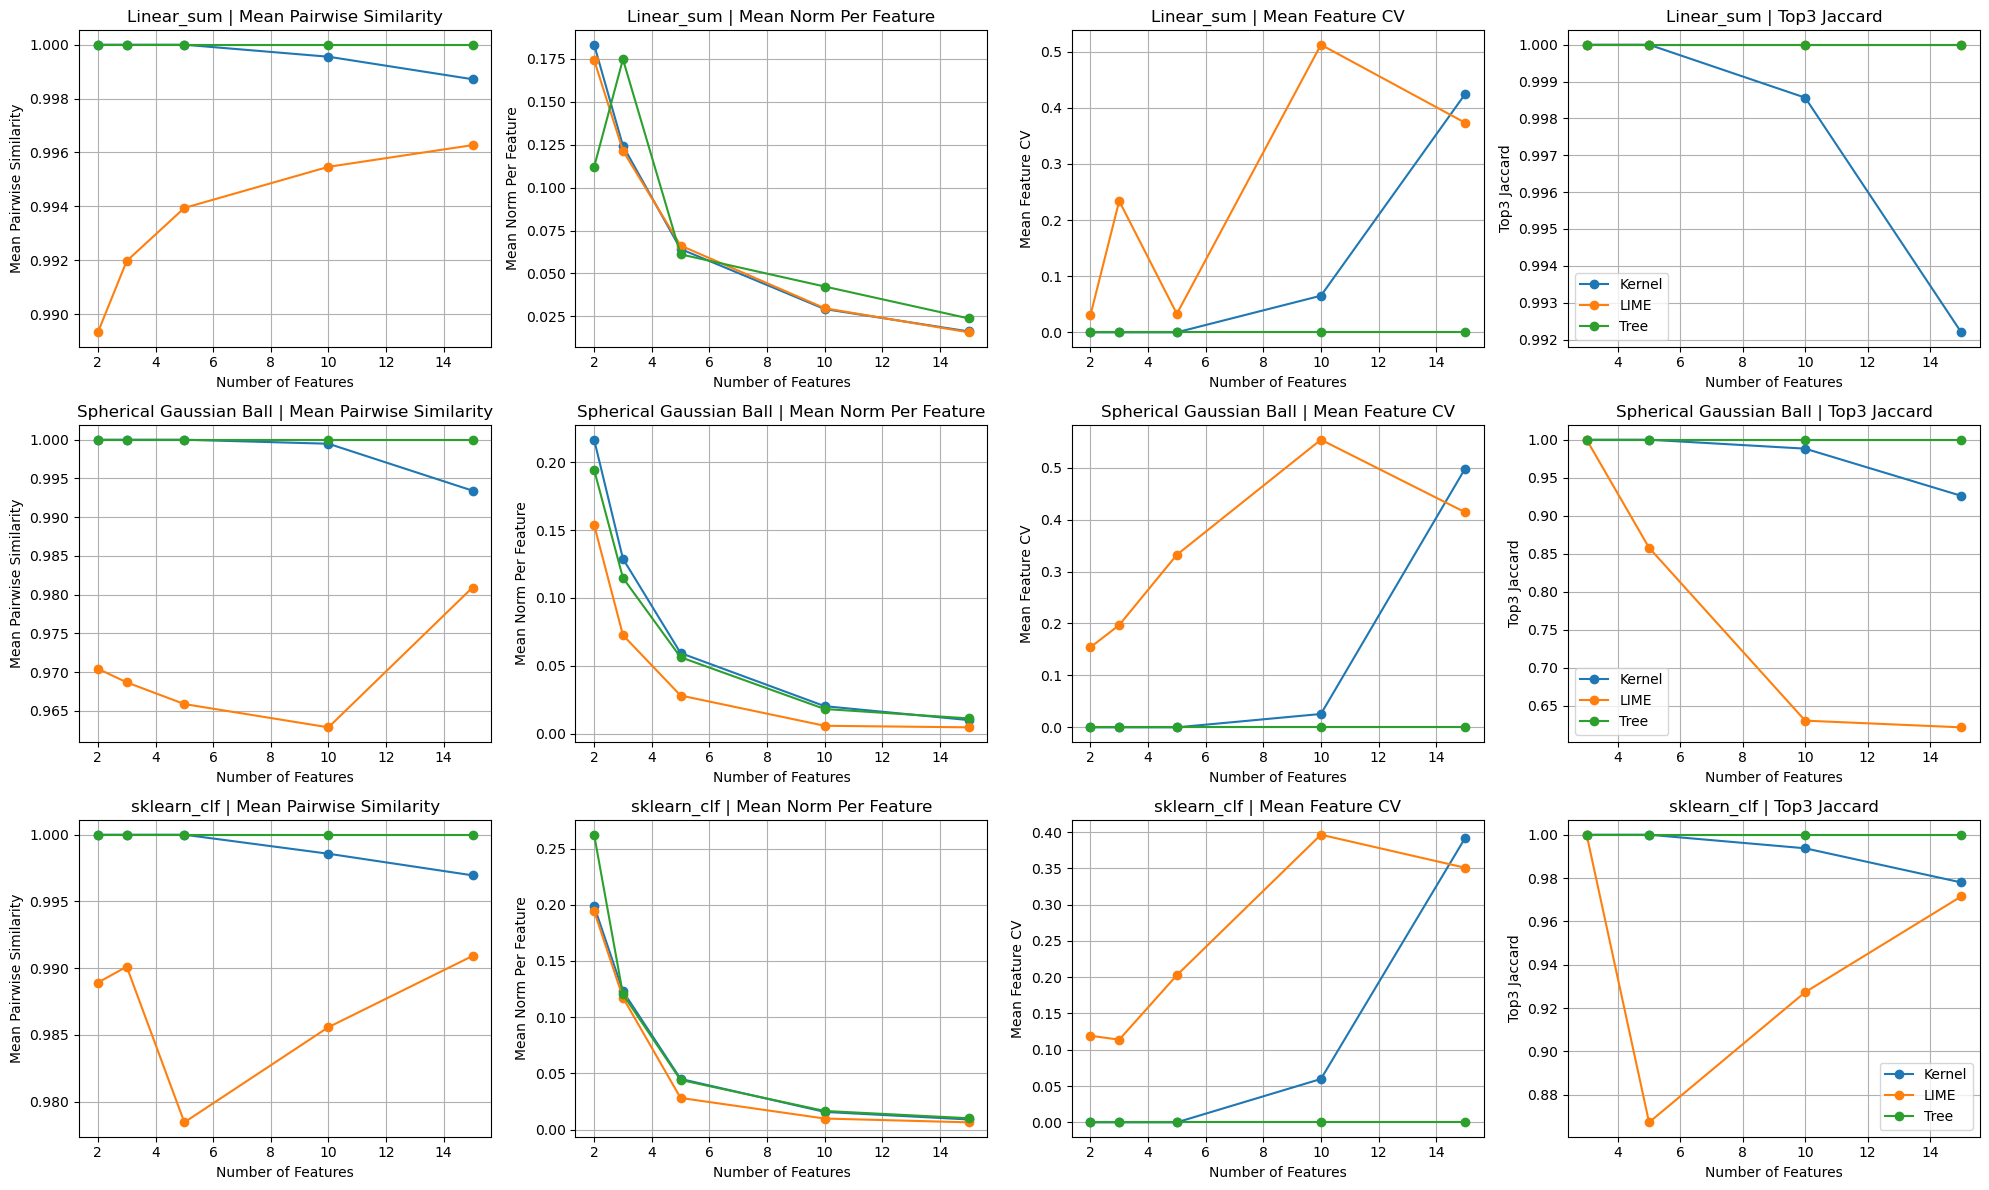

In [22]:
# Plot some useful panels

def capitalize_metric_name(metric):
    special = {'cv': 'CV', 'rf': 'RF'}
    words = []
    for w in metric.split('_'):
        words.append(special.get(w.lower(), w.capitalize()))
    return ' '.join(words)


dataset_families = agg['dataset_family'].unique()
metrics_plot = [
    'mean_pairwise_similarity',
    'mean_norm_per_feature',
    'mean_feature_cv',
    'top3_jaccard'
]

nrows = len(dataset_families)
ncols = len(metrics_plot)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
    squeeze=False
)

for i, family in enumerate(dataset_families):
    sub = agg[agg['dataset_family'] == family]
    for j, metric in enumerate(metrics_plot):
        ax = axes[i, j]
        for method in sub['method'].unique():
            s2 = (
                sub[sub['method'] == method]
                .sort_values('n_features')
            )
            ax.plot(
                s2['n_features'],
                s2[metric],
                marker='o',
                label=display_method_name(method)
            )

        ax.set_xlabel('Number of Features')
        ax.set_ylabel(capitalize_metric_name(metric))
        ax.set_title(f"{family} | {capitalize_metric_name(metric)}")
        ax.grid(True)

        # Show legend only on the left panel
        if j == ncols - 1:
            ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [23]:
# Save RF perf summary again and display join to agg (simple join) 
df_rf_perf = pd.read_csv('rf_performance_summary.csv') 
print("\nRF performance summary (per n_features/dataset):") 
display(df_rf_perf) 


RF performance summary (per n_features/dataset):


,n_features,dataset_family,n_instances_test,rf_accuracy,rf_auc
0,2,Linear_sum,100,0.77,0.832933
1,2,Spherical Gaussian Ball,100,0.93,0.991987
2,2,sklearn_clf,100,0.92,0.983766
3,3,Linear_sum,100,0.91,0.971899
4,3,Spherical Gaussian Ball,100,0.92,0.987185
5,3,sklearn_clf,100,0.94,0.974190
6,5,Linear_sum,100,0.94,0.984143
7,5,Spherical Gaussian Ball,100,0.83,0.920455
8,5,sklearn_clf,100,0.96,0.994212
9,10,Linear_sum,100,0.92,0.963280


In [24]:
stat_rows = []
for nf, g in df_big.groupby('n_features'):
    per_method = {}
    for method, g2 in g.groupby('method'):
        per_method[method] = g2['mean_pairwise_similarity'].values
    methods = sorted(per_method.keys())
    arrays = [per_method[m] for m in methods]
    min_len = min(len(a) for a in arrays)
    if min_len < 3:
        stat_rows.append({'n_features': int(nf), 'test':'friedman', 'stat':np.nan, 'p':np.nan, 'note':'not enough instances'})
        continue
    arrays_trim = [a[:min_len] for a in arrays]
    try:
        stat, p = friedmanchisquare(*arrays_trim)
        stat_rows.append({'n_features': int(nf), 'test':'friedman', 'stat': float(stat), 'p': float(p), 'note': ''})
    except Exception as e:
        stat, p = kruskal(*arrays)
        stat_rows.append({'n_features': int(nf), 'test':'kruskal', 'stat': float(stat), 'p': float(p), 'note': 'friedman failed; used kruskal'})
stat_df = pd.DataFrame(stat_rows)
stat_df.to_csv('big_results_stat_tests.csv', index=False)
print("Saved big_results_stat_tests.csv")
display(stat_df)

Saved big_results_stat_tests.csv


,n_features,test,stat,p,note
0,2,friedman,600.000000,5.148200e-131,
1,3,friedman,600.000000,5.148200e-131,
2,5,friedman,600.000000,5.148200e-131,
3,10,friedman,600.000000,5.148200e-131,
4,15,friedman,580.666667,8.125225e-127,


In [25]:
def safe_wilcoxon_vs_value(vals, test_value=1.0, alternative='less'):
    """Wilcoxon signed-rank test of median(vals) < test_value. Returns dict with handling of degenerate cases."""
    vals = np.asarray(vals)
    mask = ~np.isnan(vals)
    vals = vals[mask]
    if vals.size == 0:
        return {'n':0, 'stat':np.nan, 'p':np.nan, 'note':'no data'}
    diffs = vals - test_value
    # If all diffs are zero -> no variability
    if np.allclose(diffs, 0):
        return {'n': int(vals.size), 'stat': np.nan, 'p': np.nan, 'note': 'all equal to test value (degenerate)'}
    # If very few non-zero diffs, wilcoxon may fail. Filter zeros.
    nz = diffs != 0
    if nz.sum() < 1:
        return {'n': int(vals.size), 'stat': np.nan, 'p': np.nan, 'note': 'not enough non-zero differences'}
    try:
        stat, p = wilcoxon(diffs[nz], alternative=alternative)
        return {'n': int(vals.size), 'stat': float(stat), 'p': float(p), 'note': ''}
    except Exception as e:
        return {'n': int(vals.size), 'stat': np.nan, 'p': np.nan, 'note': f'wilcoxon failed: {e}'}


def boot_mean_ci(vals, n_boot=2000, alpha=0.05, seed=13):
    vals = np.asarray(vals)
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.RandomState(seed)
    boot_means = []
    for _ in range(n_boot):
        s = rng.choice(vals, size=vals.size, replace=True)
        boot_means.append(s.mean())
    lo = np.percentile(boot_means, 100*(alpha/2))
    hi = np.percentile(boot_means, 100*(1-alpha/2))
    return float(vals.mean()), (float(lo), float(hi))

In [26]:
# Primary stability metric to use for statistical tests
STABILITY_METRIC = 'mean_pairwise_similarity'  # values in [0,1], 1==perfect stability

In [27]:
# RQ1 - Are explanations stable across repeated runs?
# Strategy:
#  - For each dataset (or dataset_family) and method, consider the distribution of per-instance STABILITY_METRIC.
#  - Report mean/median/proportion<1 and bootstrap CI for the mean.
#  - Test whether the metric is statistically < 1 using a one-sample Wilcoxon signed-rank test against 1.

rq1_rows = []
for (ds_col, ds_val) in [('dataset', None), ('dataset_family', None)]:
    # We'll support both 'dataset' (2D experiments) and 'dataset_family' (big experiments). Only the column that exists will be used.
    if ds_col not in df_big.columns:
        continue
    for group_val, g in df_big.groupby([ds_col, 'method']):
        ds, method = group_val
        vals = g[STABILITY_METRIC].values
        mean, (lo, hi) = boot_mean_ci(vals)
        med = np.nanmedian(vals)
        std = np.nanstd(vals, ddof=1)
        n = int(np.sum(~np.isnan(vals)))
        prop_less1 = np.sum(vals < 1.0) / float(n) if n>0 else np.nan
        wil = safe_wilcoxon_vs_value(vals, test_value=1.0, alternative='less')
        rq1_rows.append({
            ds_col: ds,
            'method': method,
            'n_instances': n,
            'mean': mean,
            'mean_95ci_lo': lo,
            'mean_95ci_hi': hi,
            'median': float(med) if not np.isnan(med) else np.nan,
            'std': float(std) if not np.isnan(std) else np.nan,
            'prop_less_than_1': float(prop_less1) if not np.isnan(prop_less1) else np.nan,
            'wilcoxon_stat': wil.get('stat'),
            'wilcoxon_p': wil.get('p'),
            'wilcoxon_note': wil.get('note')
        })

rq1_df = pd.DataFrame(rq1_rows)
rq1_df.to_csv('stat_rq1_summary.csv', index=False)
print('Saved stat_rq1_summary.csv')
display(rq1_df)

Saved stat_rq1_summary.csv


,dataset_family,method,n_instances,mean,mean_95ci_lo,mean_95ci_hi,median,std,prop_less_than_1,wilcoxon_stat,wilcoxon_p,wilcoxon_note
0,Linear_sum,kernel,500,0.999655,0.999600,0.999708,1.000000,0.000657,0.4,0.0,7.180732e-35,
1,Linear_sum,lime,500,0.993393,0.993119,0.993640,0.994113,0.002924,1.0,0.0,6.323595e-84,
2,Linear_sum,tree,500,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,NaN,NaN,all equal to test value (degenerate)
3,Spherical Gaussian Ball,kernel,500,0.998581,0.998248,0.998881,1.000000,0.003578,0.4,0.0,7.180732e-35,
4,Spherical Gaussian Ball,lime,500,0.969746,0.967862,0.971320,0.973553,0.019465,1.0,0.0,6.323595e-84,
5,Spherical Gaussian Ball,tree,500,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,NaN,NaN,all equal to test value (degenerate)
6,sklearn_clf,kernel,500,0.999106,0.998971,0.999238,1.000000,0.001545,0.4,0.0,7.180732e-35,
7,sklearn_clf,lime,500,0.986792,0.986321,0.987226,0.988409,0.005248,1.0,0.0,6.323595e-84,
8,sklearn_clf,tree,500,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,NaN,NaN,all equal to test value (degenerate)


In [28]:
# RQ2 - Does stability differ across XAI methods and data types?
# Strategy:
#  - For each dataset_family (big multi-feature) and n_features, treat instances as blocks and methods as treatments.
#  - Run Friedman test (non-parametric repeated measures). If assumptions fail, use Kruskal-Wallis as fallback.
#  - If omnibus significant, run pairwise Wilcoxon signed-rank tests (paired) with Bonferroni correction.

rq2_friedman = []
rq2_pairwise = []

for (nf, family), g in df_big.groupby(['n_features', 'dataset_family']):
    methods = sorted(g['method'].unique())
    # Build matrix: methods × instances (aligned by instance_idx)
    mat = []
    for m in methods:
        arr = (
            g[g['method'] == m]
            .sort_values('instance_idx')[STABILITY_METRIC]
            .to_numpy()
        )
        mat.append(arr)
    mat = np.vstack(mat)  # shape: (n_methods, n_instances)

    # Drop instances with any NaNs (required for paired tests)
    valid_mask = ~np.isnan(mat).any(axis=0)
    mat_ok = mat[:, valid_mask]
    n_methods, n_blocks = mat_ok.shape

    # ---- Guard conditions ----
    if n_methods < 2 or n_blocks < 3:
        rq2_friedman.append({
            'n_features': int(nf),
            'dataset_family': family,
            'test': 'friedman',
            'stat': np.nan,
            'p': np.nan,
            'n_blocks': int(n_blocks),
            'note': 'insufficient data'
        })
        continue

    # Degenerate case: all methods identical for all instances
    if np.allclose(mat_ok, mat_ok[0]):
        rq2_friedman.append({
            'n_features': int(nf),
            'dataset_family': family,
            'test': 'friedman',
            'stat': 0.0,
            'p': 1.0,
            'n_blocks': int(n_blocks),
            'note': 'no variability across methods'
        })
        continue

    # ---- Omnibus test ----
    try:
        stat, p = friedmanchisquare(*[mat_ok[i] for i in range(n_methods)])
        test_used = 'friedman'
        note = ''
    except Exception as e:
        # Fallback to Kruskal–Wallis (unpaired)
        try:
            stat, p = kruskal(*[mat_ok[i] for i in range(n_methods)])
            test_used = 'kruskal'
            note = 'friedman failed; used kruskal'
        except Exception as e2:
            rq2_friedman.append({
                'n_features': int(nf),
                'dataset_family': family,
                'test': 'friedman/kruskal',
                'stat': np.nan,
                'p': np.nan,
                'n_blocks': int(n_blocks),
                'note': f'failed: {e} / {e2}'
            })
            continue

    rq2_friedman.append({
        'n_features': int(nf),
        'dataset_family': family,
        'test': test_used,
        'stat': float(stat),
        'p': float(p),
        'n_blocks': int(n_blocks),
        'note': note
    })

    #  Pairwise post-hoc tests
    if p < 0.05:
        pairs = []
        for i in range(n_methods):
            for j in range(i + 1, n_methods):
                a = mat_ok[i]
                b = mat_ok[j]
                # Drop NaNs (should already be none, but safe)
                mask = ~np.isnan(a) & ~np.isnan(b)
                a1, b1 = a[mask], b[mask]
                if len(a1) < 3:
                    pairs.append({
                        'n_features': int(nf),
                        'dataset_family': family,
                        'method_a': methods[i],
                        'method_b': methods[j],
                        'wilcox_stat': np.nan,
                        'wilcox_p': np.nan,
                        'n': len(a1),
                        'note': 'too few paired samples'
                    })
                    continue
                # Degenerate paired case
                if np.allclose(a1, b1):
                    pairs.append({
                        'n_features': int(nf),
                        'dataset_family': family,
                        'method_a': methods[i],
                        'method_b': methods[j],
                        'wilcox_stat': 0.0,
                        'wilcox_p': 1.0,
                        'n': len(a1),
                        'note': 'identical paired samples'
                    })
                    continue
                try:
                    stat_w, p_w = wilcoxon(a1, b1)
                    pairs.append({
                        'n_features': int(nf),
                        'dataset_family': family,
                        'method_a': methods[i],
                        'method_b': methods[j],
                        'wilcox_stat': float(stat_w),
                        'wilcox_p': float(p_w),
                        'n': len(a1),
                        'note': ''
                    })
                except Exception as e:
                    pairs.append({
                        'n_features': int(nf),
                        'dataset_family': family,
                        'method_a': methods[i],
                        'method_b': methods[j],
                        'wilcox_stat': np.nan,
                        'wilcox_p': np.nan,
                        'n': len(a1),
                        'note': f'wilcoxon failed: {e}'
                    })

        # Bonferroni correction 
        raw_pvals = [r['wilcox_p'] for r in pairs]
        valid_idx = [i for i, v in enumerate(raw_pvals) if not np.isnan(v)]
        if valid_idx:
            pvals_to_adjust = [raw_pvals[i] for i in valid_idx]
            reject, p_adj, _, _ = multipletests(pvals_to_adjust, method='bonferroni')

            for k, idx in enumerate(valid_idx):
                pairs[idx]['wilcox_p_bonf'] = float(p_adj[k])
                pairs[idx]['wilcox_reject_bonf'] = bool(reject[k])
        rq2_pairwise.extend(pairs)

# Save results
rq2_friedman_df = pd.DataFrame(rq2_friedman)
rq2_pairwise_df = pd.DataFrame(rq2_pairwise)

rq2_friedman_df.to_csv('stat_rq2_friedman.csv', index=False)
rq2_pairwise_df.to_csv('stat_rq2_pairwise.csv', index=False)

print('Saved stat_rq2_friedman.csv')
display(rq2_friedman_df)

print('Saved stat_rq2_pairwise.csv')
display(rq2_pairwise_df)


Saved stat_rq2_friedman.csv


,n_features,dataset_family,test,stat,p,n_blocks,note
0,2,Linear_sum,friedman,200.00,3.720076e-44,100,
1,2,Spherical Gaussian Ball,friedman,200.00,3.720076e-44,100,
2,2,sklearn_clf,friedman,200.00,3.720076e-44,100,
3,3,Linear_sum,friedman,200.00,3.720076e-44,100,
4,3,Spherical Gaussian Ball,friedman,200.00,3.720076e-44,100,
5,3,sklearn_clf,friedman,200.00,3.720076e-44,100,
6,5,Linear_sum,friedman,200.00,3.720076e-44,100,
7,5,Spherical Gaussian Ball,friedman,200.00,3.720076e-44,100,
8,5,sklearn_clf,friedman,200.00,3.720076e-44,100,
9,10,Linear_sum,friedman,200.00,3.720076e-44,100,


Saved stat_rq2_pairwise.csv


,n_features,dataset_family,method_a,method_b,wilcox_stat,wilcox_p,n,note,wilcox_p_bonf,wilcox_reject_bonf
0,2,Linear_sum,kernel,lime,0.0,3.896560e-18,100,,1.168968e-17,True
1,2,Linear_sum,kernel,tree,0.0,1.000000e+00,100,identical paired samples,1.000000e+00,False
2,2,Linear_sum,lime,tree,0.0,3.896560e-18,100,,1.168968e-17,True
3,2,Spherical Gaussian Ball,kernel,lime,0.0,3.896560e-18,100,,1.168968e-17,True
4,2,Spherical Gaussian Ball,kernel,tree,0.0,1.000000e+00,100,identical paired samples,1.000000e+00,False
5,2,Spherical Gaussian Ball,lime,tree,0.0,3.896560e-18,100,,1.168968e-17,True
6,2,sklearn_clf,kernel,lime,0.0,3.896560e-18,100,,1.168968e-17,True
7,2,sklearn_clf,kernel,tree,0.0,1.000000e+00,100,identical paired samples,1.000000e+00,False
8,2,sklearn_clf,lime,tree,0.0,3.896560e-18,100,,1.168968e-17,True
9,3,Linear_sum,kernel,lime,0.0,3.896560e-18,100,,1.168968e-17,True


In [29]:
#  RQ4 - Does instability increase with dimensionality?
# Strategy:
#  - For each dataset_family and method, compute average STABILITY_METRIC per n_features.
#  - Compute Spearman correlation between n_features and the metric.
#  - Compute linear regression slope for interpretability.

agg = df_big.groupby(['n_features','dataset_family','method'])[STABILITY_METRIC].mean().reset_index()

rq4_rows = []
for (family, method), g in agg.groupby(['dataset_family','method']):
    # g has rows for multiple n_features
    if g.shape[0] < 3:
        rq4_rows.append({'dataset_family': family, 'method': method, 'spearman_rho': np.nan, 'spearman_p': np.nan, 'n_points': int(g.shape[0]), 'linreg_slope': np.nan, 'linreg_p': np.nan, 'note': 'too few n_features'})
        continue
    rho, p = spearmanr(g['n_features'], g[STABILITY_METRIC])
    lr = linregress(g['n_features'], g[STABILITY_METRIC])
    rq4_rows.append({'dataset_family': family, 'method': method, 'spearman_rho': float(rho) if not np.isnan(rho) else np.nan, 'spearman_p': float(p) if not np.isnan(p) else np.nan, 'n_points': int(g.shape[0]), 'linreg_slope': float(lr.slope), 'linreg_p': float(lr.pvalue), 'linreg_r2': float(lr.rvalue**2)})

rq4_df = pd.DataFrame(rq4_rows)
rq4_df.to_csv('stat_rq4_trend.csv', index=False)
print('Saved stat_rq4_trend.csv')
display(rq4_df)

Saved stat_rq4_trend.csv


/var/folders/5w/ts8c5v8s2ws2qn6p8d9706tm0000gn/T/ipykernel_82421/3655215053.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(g['n_features'], g[STABILITY_METRIC])


,dataset_family,method,spearman_rho,spearman_p,n_points,linreg_slope,linreg_p,linreg_r2
0,Linear_sum,kernel,-0.894427,4.051933e-02,5,-0.000098,0.010833,0.914823
1,Linear_sum,lime,1.000000,1.404265e-24,5,0.000460,0.043474,0.790849
2,Linear_sum,tree,NaN,NaN,5,0.000000,1.000000,0.000000
3,Spherical Gaussian Ball,kernel,-0.894427,4.051933e-02,5,-0.000459,0.060158,0.743288
4,Spherical Gaussian Ball,lime,0.000000,1.000000e+00,5,0.000655,0.371186,0.268409
5,Spherical Gaussian Ball,tree,NaN,NaN,5,0.000000,1.000000,0.000000
6,sklearn_clf,kernel,-0.894427,4.051933e-02,5,-0.000243,0.004655,0.951122
7,sklearn_clf,lime,0.200000,7.470601e-01,5,0.000187,0.747190,0.039958
8,sklearn_clf,tree,NaN,NaN,5,0.000000,1.000000,0.000000
